In [1]:
import jax
from jax.config import config
config.update("jax_enable_x64", True)

In [2]:
import scanpy as sc
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
import moscot
from moscot.problems.time import TemporalProblem
import moscot.plotting as mpl

In [52]:
adata = sc.read_h5ad("/lustre/groups/ml01/workspace/moscot_paper/pancreas/pancreas_multiome_2022_multiVI_embedding.h5ad")

In [53]:
endocrine_celltypes = [
    "Ngn3 low",
    "Ngn3 high",
    "Ngn3 high cycling",
    "Fev+",
    "Fev+ Alpha",
    "Fev+ Beta",
    "Fev+ Delta",
    "Eps/Delta progenitors",
    "Alpha",
    "Beta",
    "Delta",
    "Epsilon"
]

In [54]:
adata_red = adata[adata.obs["celltype"].isin(endocrine_celltypes)]

In [55]:
adata_removed = adata[~adata.obs["celltype"].isin(endocrine_celltypes)]

In [56]:
adata_removed.obs["celltype"].cat.categories

Index(['Ductal', 'Imm. Acinar', 'Mat. Acinar', 'Prlf. Ductal'], dtype='object')

In [57]:
adata_red.obs["celltype"].cat.categories

Index(['Alpha', 'Beta', 'Delta', 'Eps/Delta progenitors', 'Epsilon', 'Fev+',
       'Fev+ Alpha', 'Fev+ Beta', 'Fev+ Delta', 'Ngn3 high',
       'Ngn3 high cycling', 'Ngn3 low'],
      dtype='object')

In [58]:
adata = adata_red.copy()

In [59]:
adata.obs['time'] = adata.obs.apply(lambda x: 14.5 if x["sample"]=="E14.5" else 15.5, axis=1)

In [60]:
sc.tl.umap(adata)

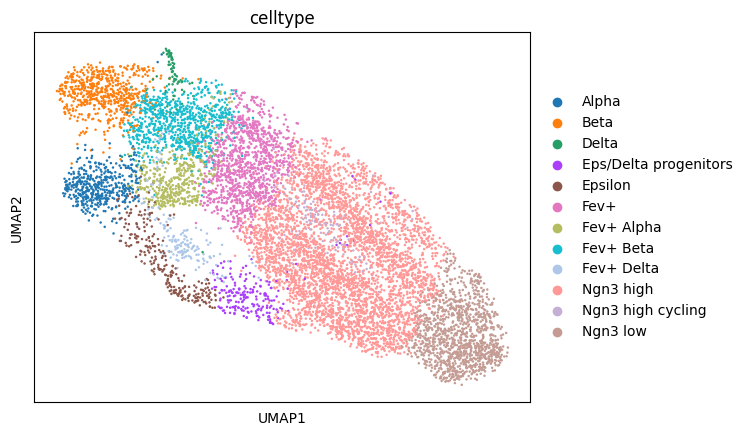

In [61]:
sc.pl.umap(adata, color="celltype")

In [62]:
sc.tl.leiden(adata, restrict_to=("celltype", ["Eps/Delta progenitors"]), resolution=0.3, key_added="tmp_1")


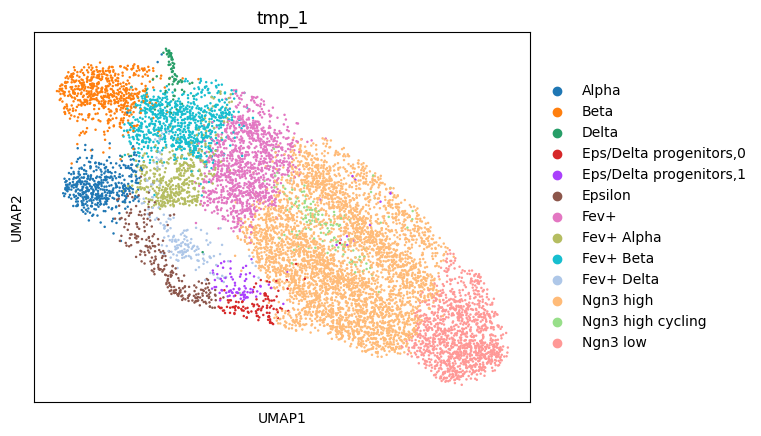

In [63]:
sc.pl.umap(adata, color="tmp_1")

In [64]:
sc.tl.leiden(adata, restrict_to=("tmp_1", ["Ngn3 high"]), resolution=0.5, key_added="tmp_2")


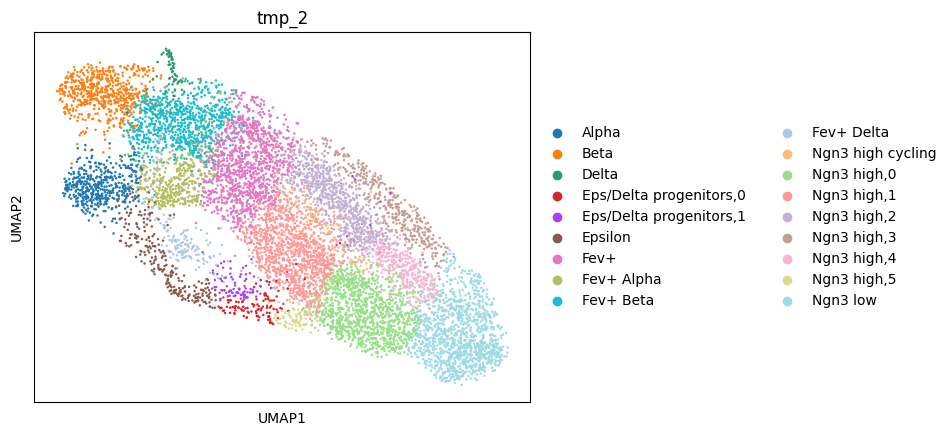

In [65]:
sc.pl.umap(adata, color="tmp_2")

In [66]:
adata.obs["celltype_refined"] = adata.obs["tmp_2"]

In [67]:
x,y = 'sample', 'celltype_refined'
df = adata.obs.copy()
df1 = df.groupby(x)[y].value_counts(normalize=True)
df1 = df1.mul(100)
df1 = df1.rename('percent').reset_index()

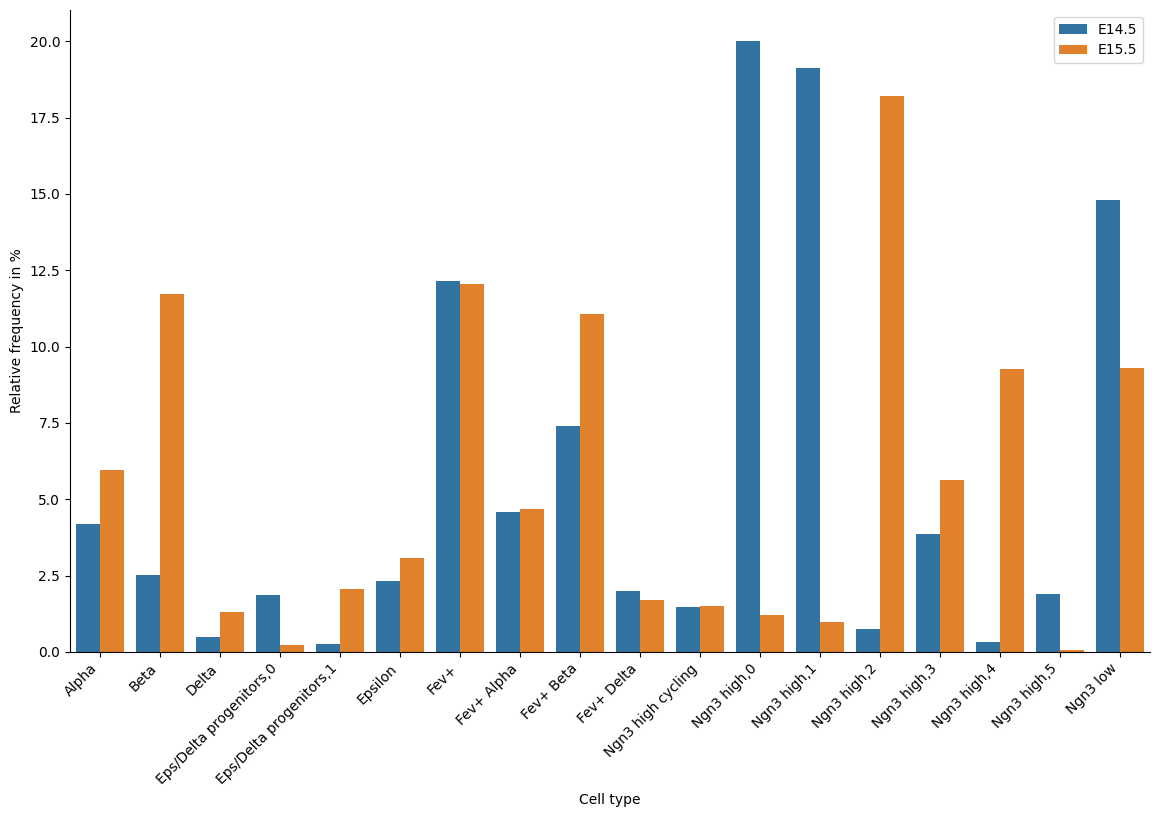

In [68]:
import seaborn as sns

g = sns.catplot(x="level_1",y='percent',hue=x,kind='bar',data=df1, legend=False,height=8.27, aspect=11.7/8.27)
plt.xlabel("Cell type")
plt.ylabel("Relative frequency in %")
plt.xticks(rotation=45, ha='right')
plt.legend(loc='upper right')
plt.tight_layout()


# MultiVI space

In [126]:
tp0 = TemporalProblem(adata)
#tp0 = tp0.score_genes_for_marginals(gene_set_proliferation="mouse", gene_set_apoptosis="mouse")
tp0 = tp0.prepare("time", joint_attr="X_multi_vi")

In [127]:
tp0 = tp0.solve(epsilon=1e-2, scale_cost="mean")

In [71]:
ct_desc = tp0.cell_transition(start=14.5, end=15.5, early_annotation="celltype_refined", late_annotation="celltype_refined", forward=True)

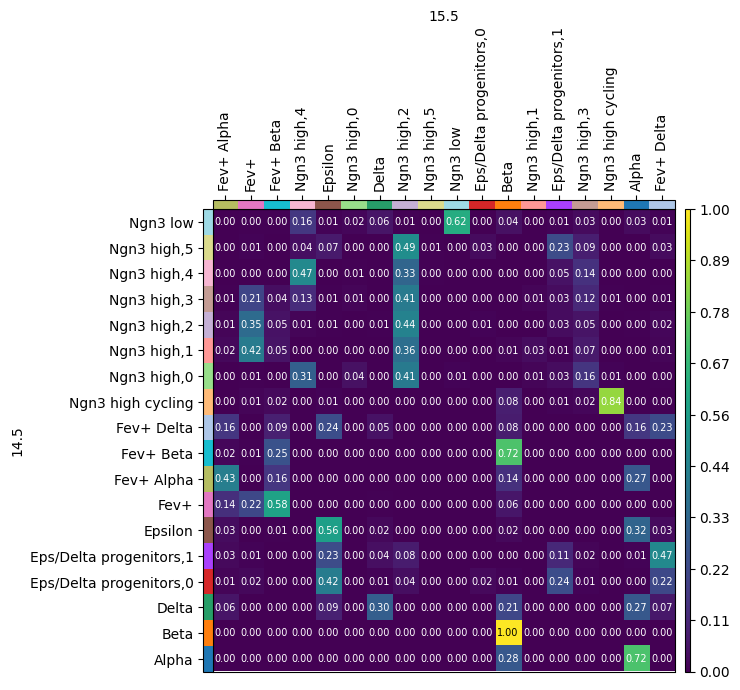

In [72]:
mpl.cell_transition(tp0, dpi=100, fontsize=7)

In [73]:
ct_desc = tp0.cell_transition(start=14.5, end=15.5, early_annotation="celltype_refined", late_annotation="celltype_refined", forward=False)

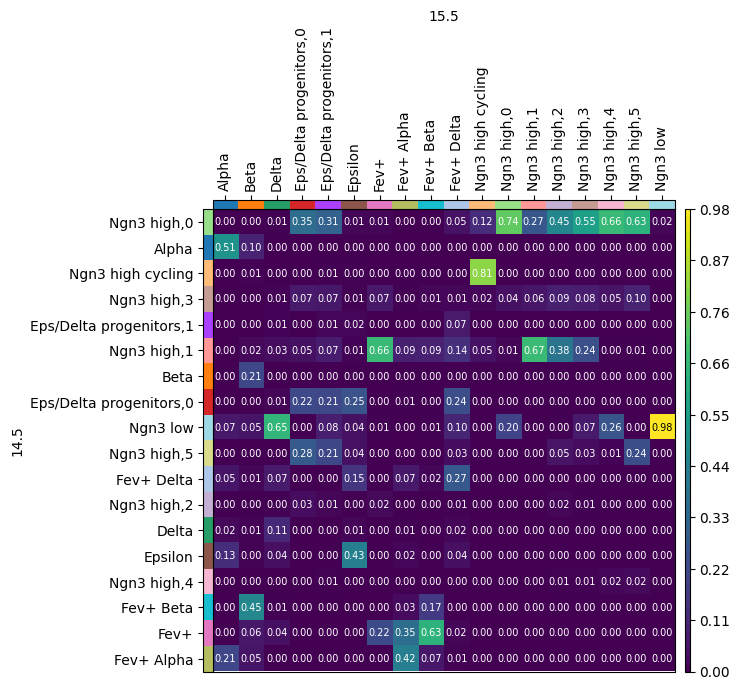

In [74]:
mpl.cell_transition(tp0, dpi=100, fontsize=7)

In [75]:
tp0.push(14.5, 15.5, data="celltype_refined", subset="Eps/Delta progenitors,0")

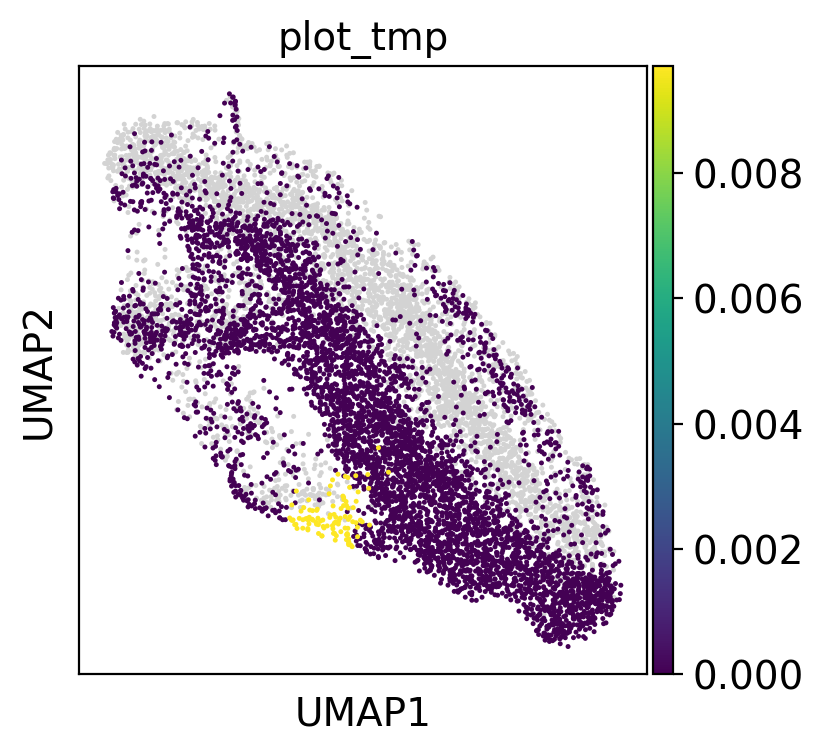

In [76]:
mpl.push(tp0, time_points=[14.5])

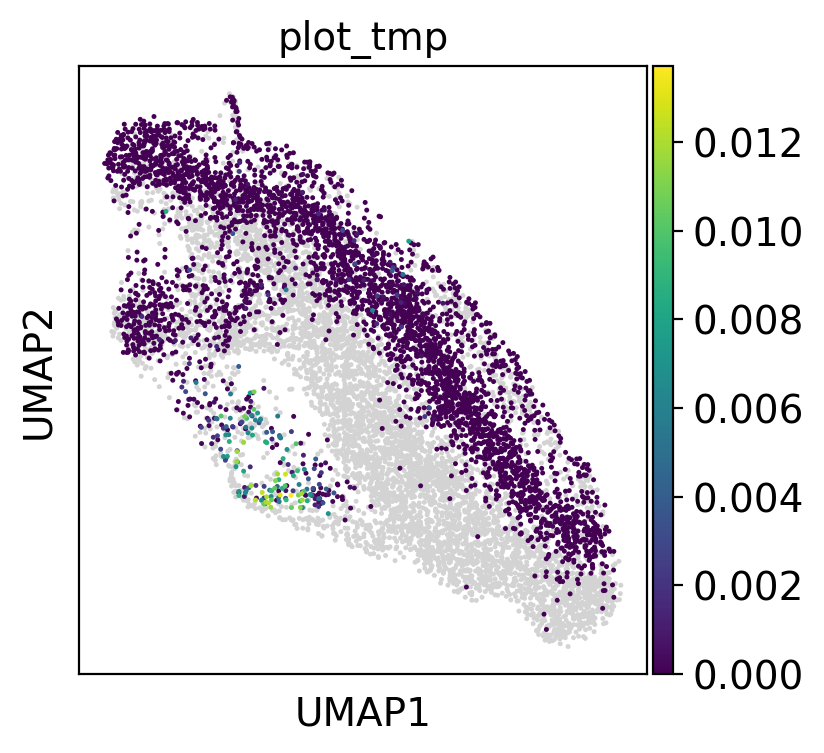

In [77]:
mpl.push(tp0, time_points=[15.5])

In [79]:
tp0.push(14.5, 15.5, data="celltype_refined", subset="Eps/Delta progenitors,1")

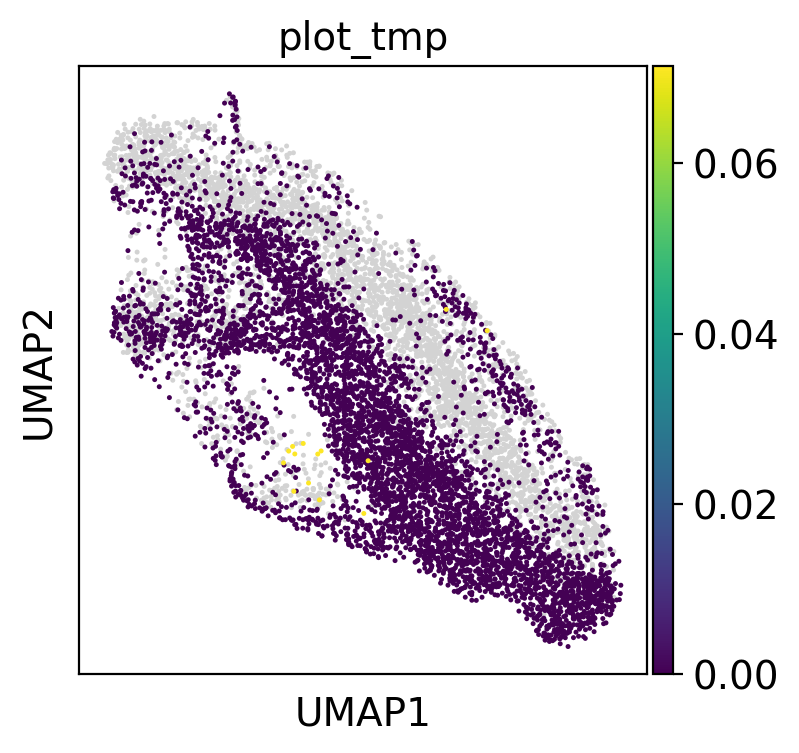

In [80]:
mpl.push(tp0, time_points=[14.5])

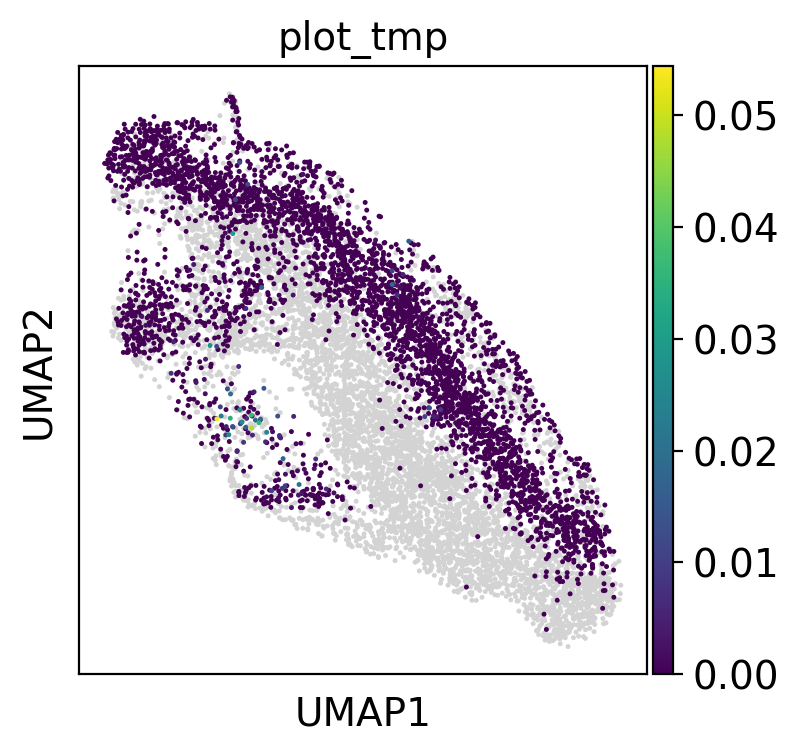

In [81]:
mpl.push(tp0, time_points=[15.5])

In [82]:
tp0.pull(14.5, 15.5, data="celltype_refined", subset="Epsilon")

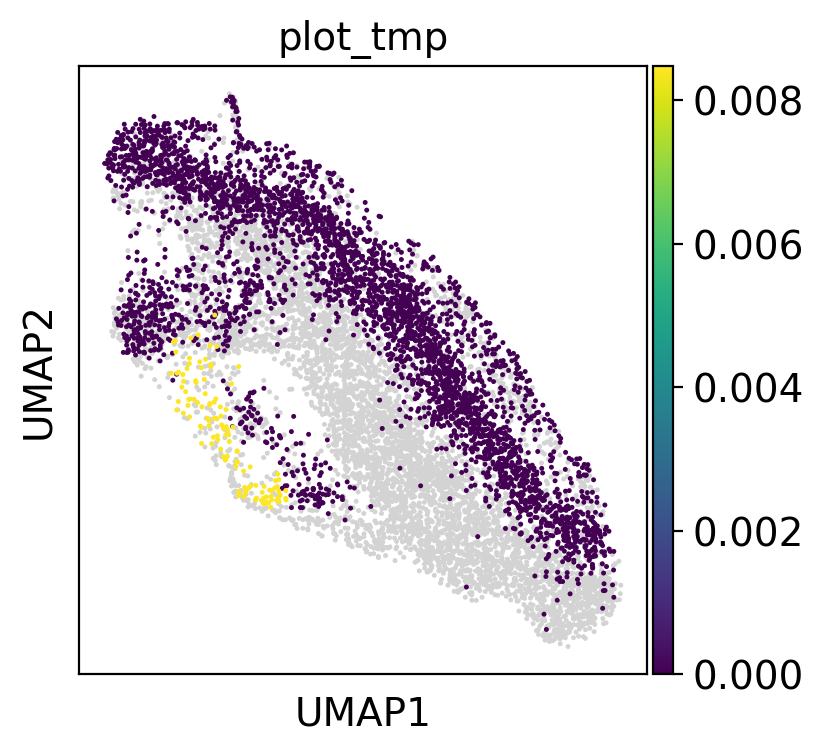

In [85]:
mpl.pull(tp0, time_points=[15.5])

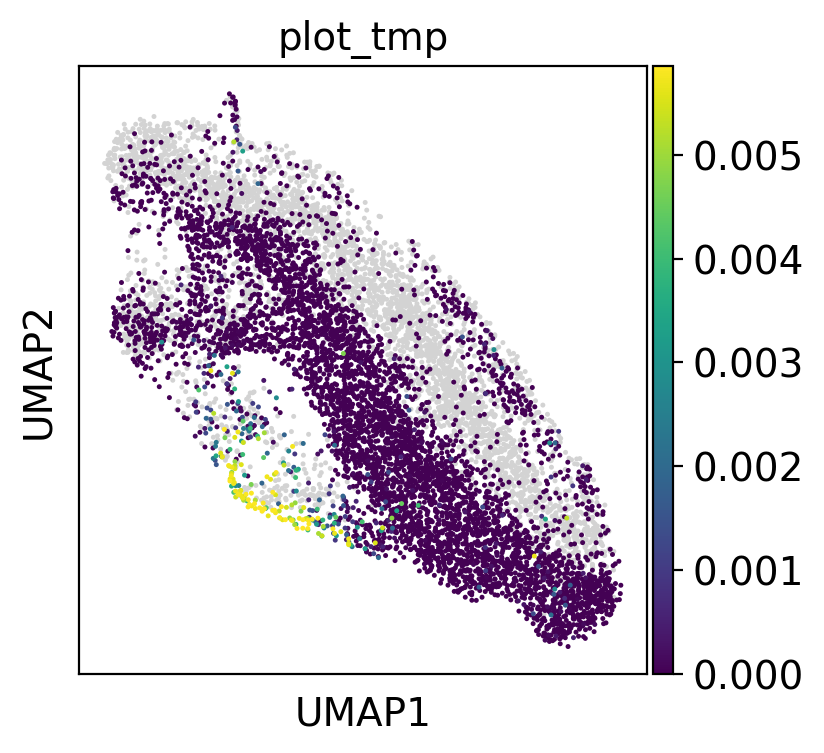

In [83]:
mpl.pull(tp0, time_points=[14.5])

In [86]:
tp0.pull(14.5, 15.5, data="celltype_refined", subset="Delta")

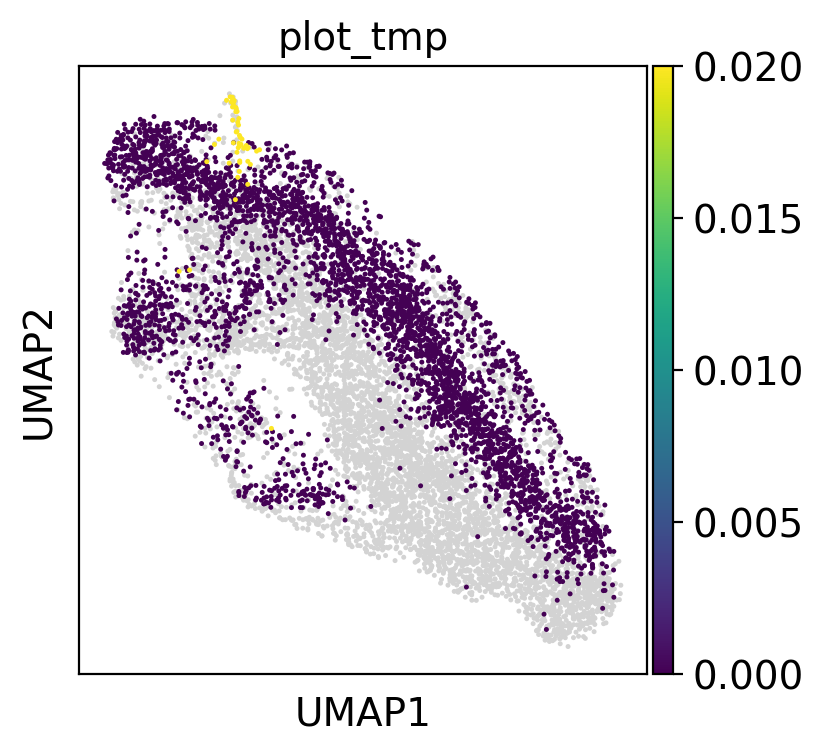

In [87]:
mpl.pull(tp0, time_points=[15.5])

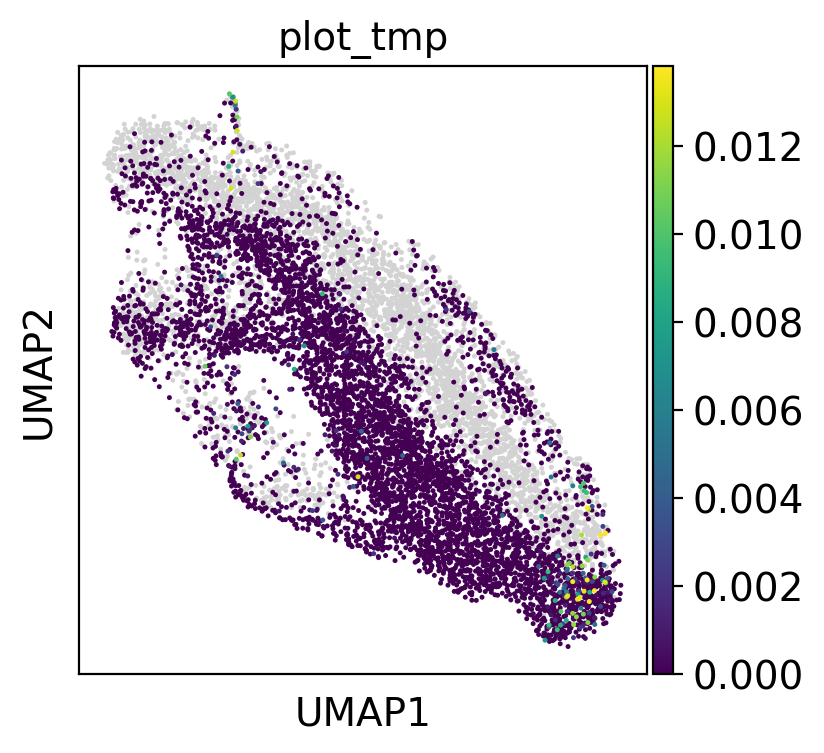

In [88]:
mpl.pull(tp0, time_points=[14.5])

In [89]:
tp0.pull(14.5, 15.5, data="celltype_refined", subset="Fev+ Delta")

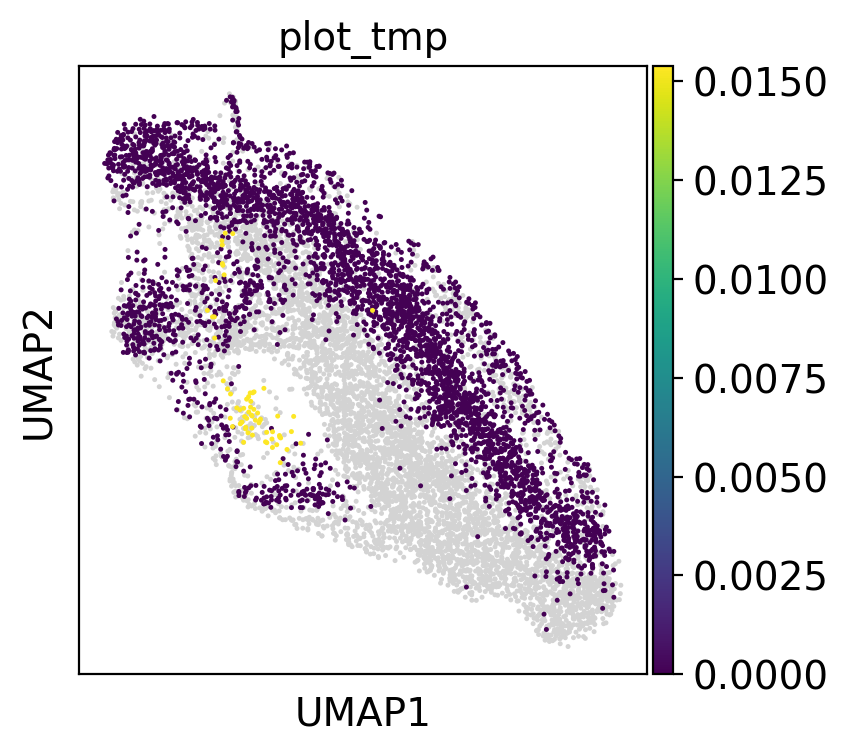

In [90]:
mpl.pull(tp0, time_points=[15.5])

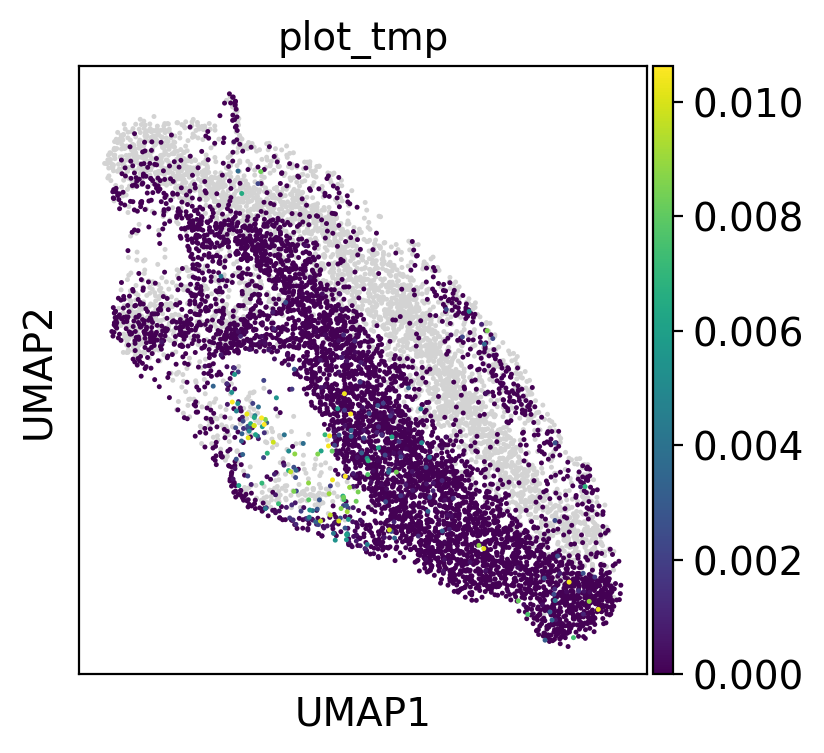

In [91]:
mpl.pull(tp0, time_points=[14.5])

In [134]:
tp0.push(14.5, 15.5, data="celltype_refined", subset="Fev+ Delta")

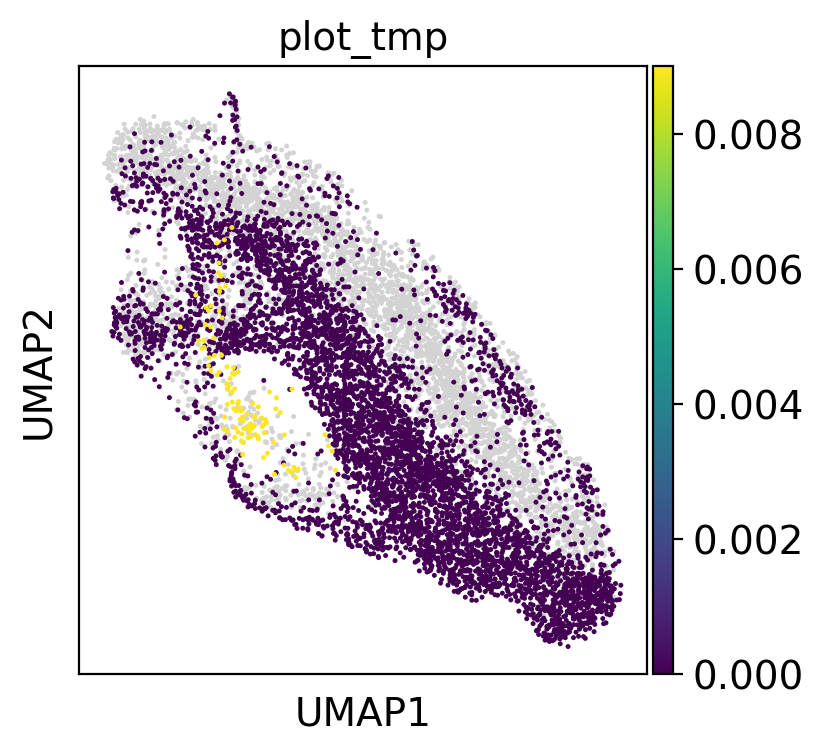

In [135]:
mpl.push(tp0, time_points=[14.5])

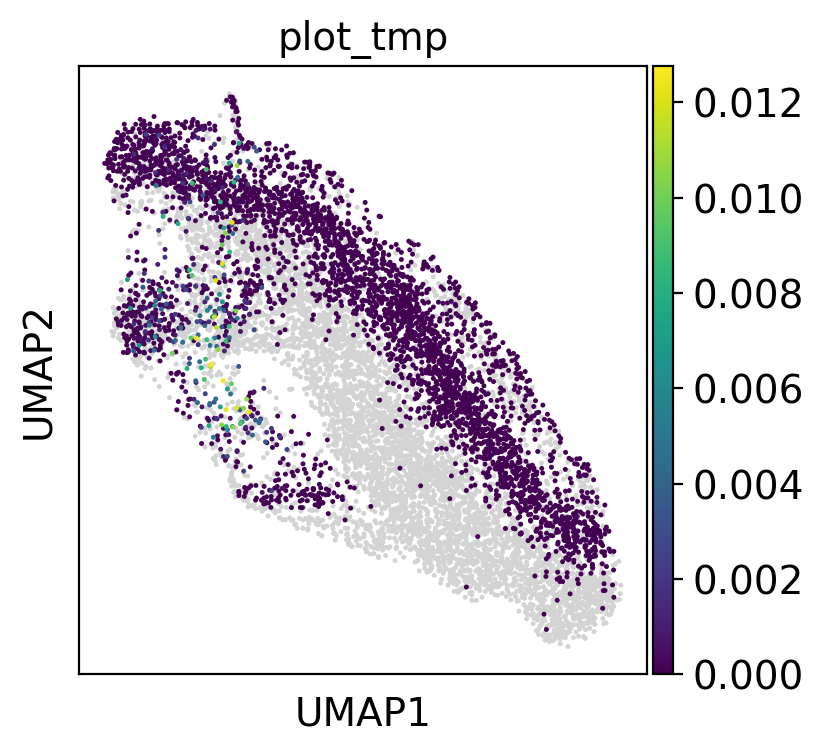

In [136]:
mpl.push(tp0, time_points=[15.5])

In [137]:
sc.tl.leiden(adata, restrict_to=("celltype_refined", ["Fev+ Delta"]), resolution=0.5, key_added="tmp_3")

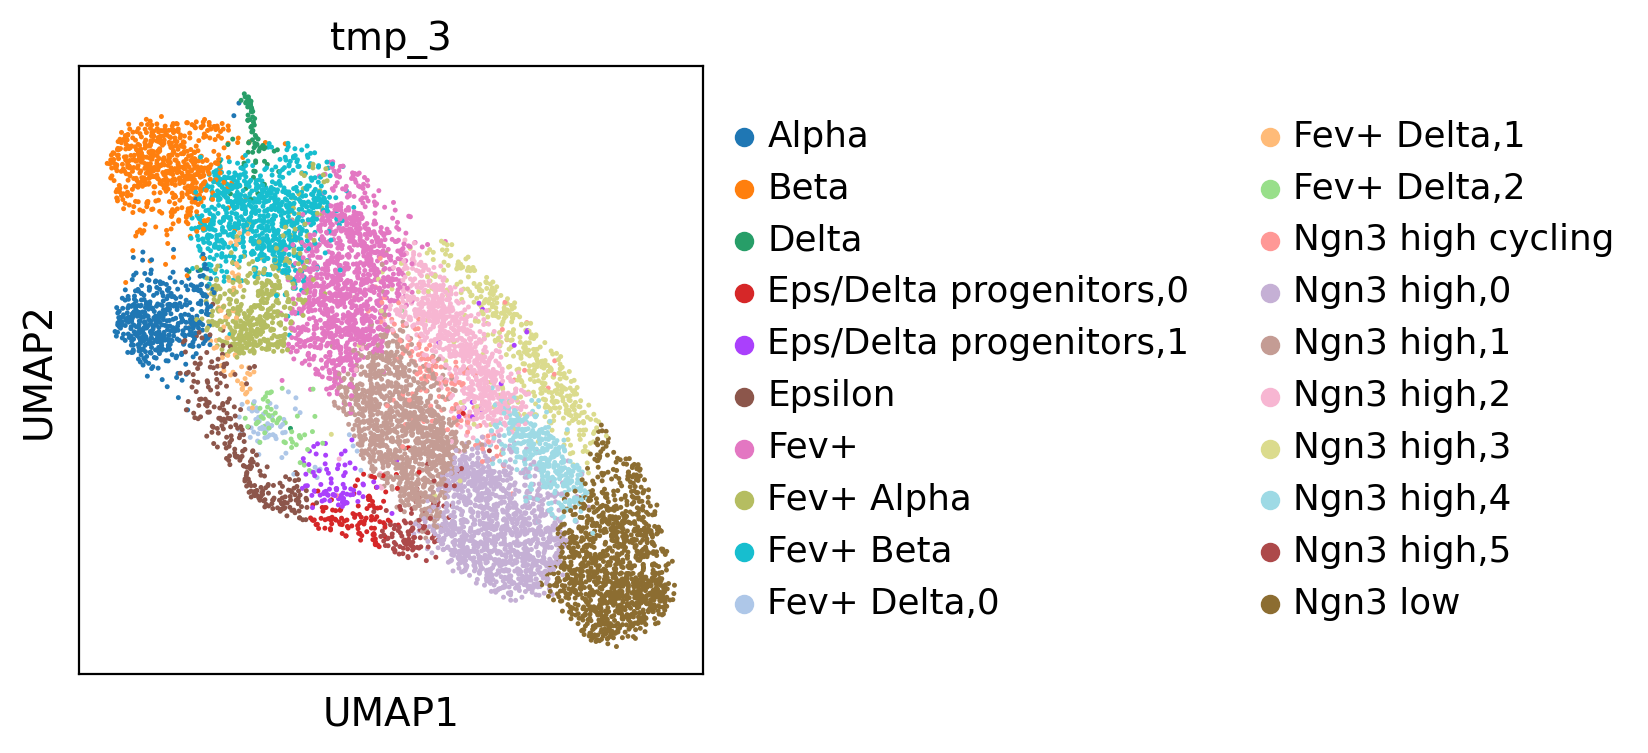

In [138]:
sc.pl.umap(adata, color="tmp_3")

In [139]:
tp1 = TemporalProblem(adata)
tp1 = tp0.prepare("time", joint_attr="X_multi_vi")
tp1 = tp0.solve(epsilon=1e-2, scale_cost="mean")

In [141]:
_ = tp1.cell_transition(14.5, 15.5, early_annotation="tmp_3", late_annotation="tmp_3", forward=True)

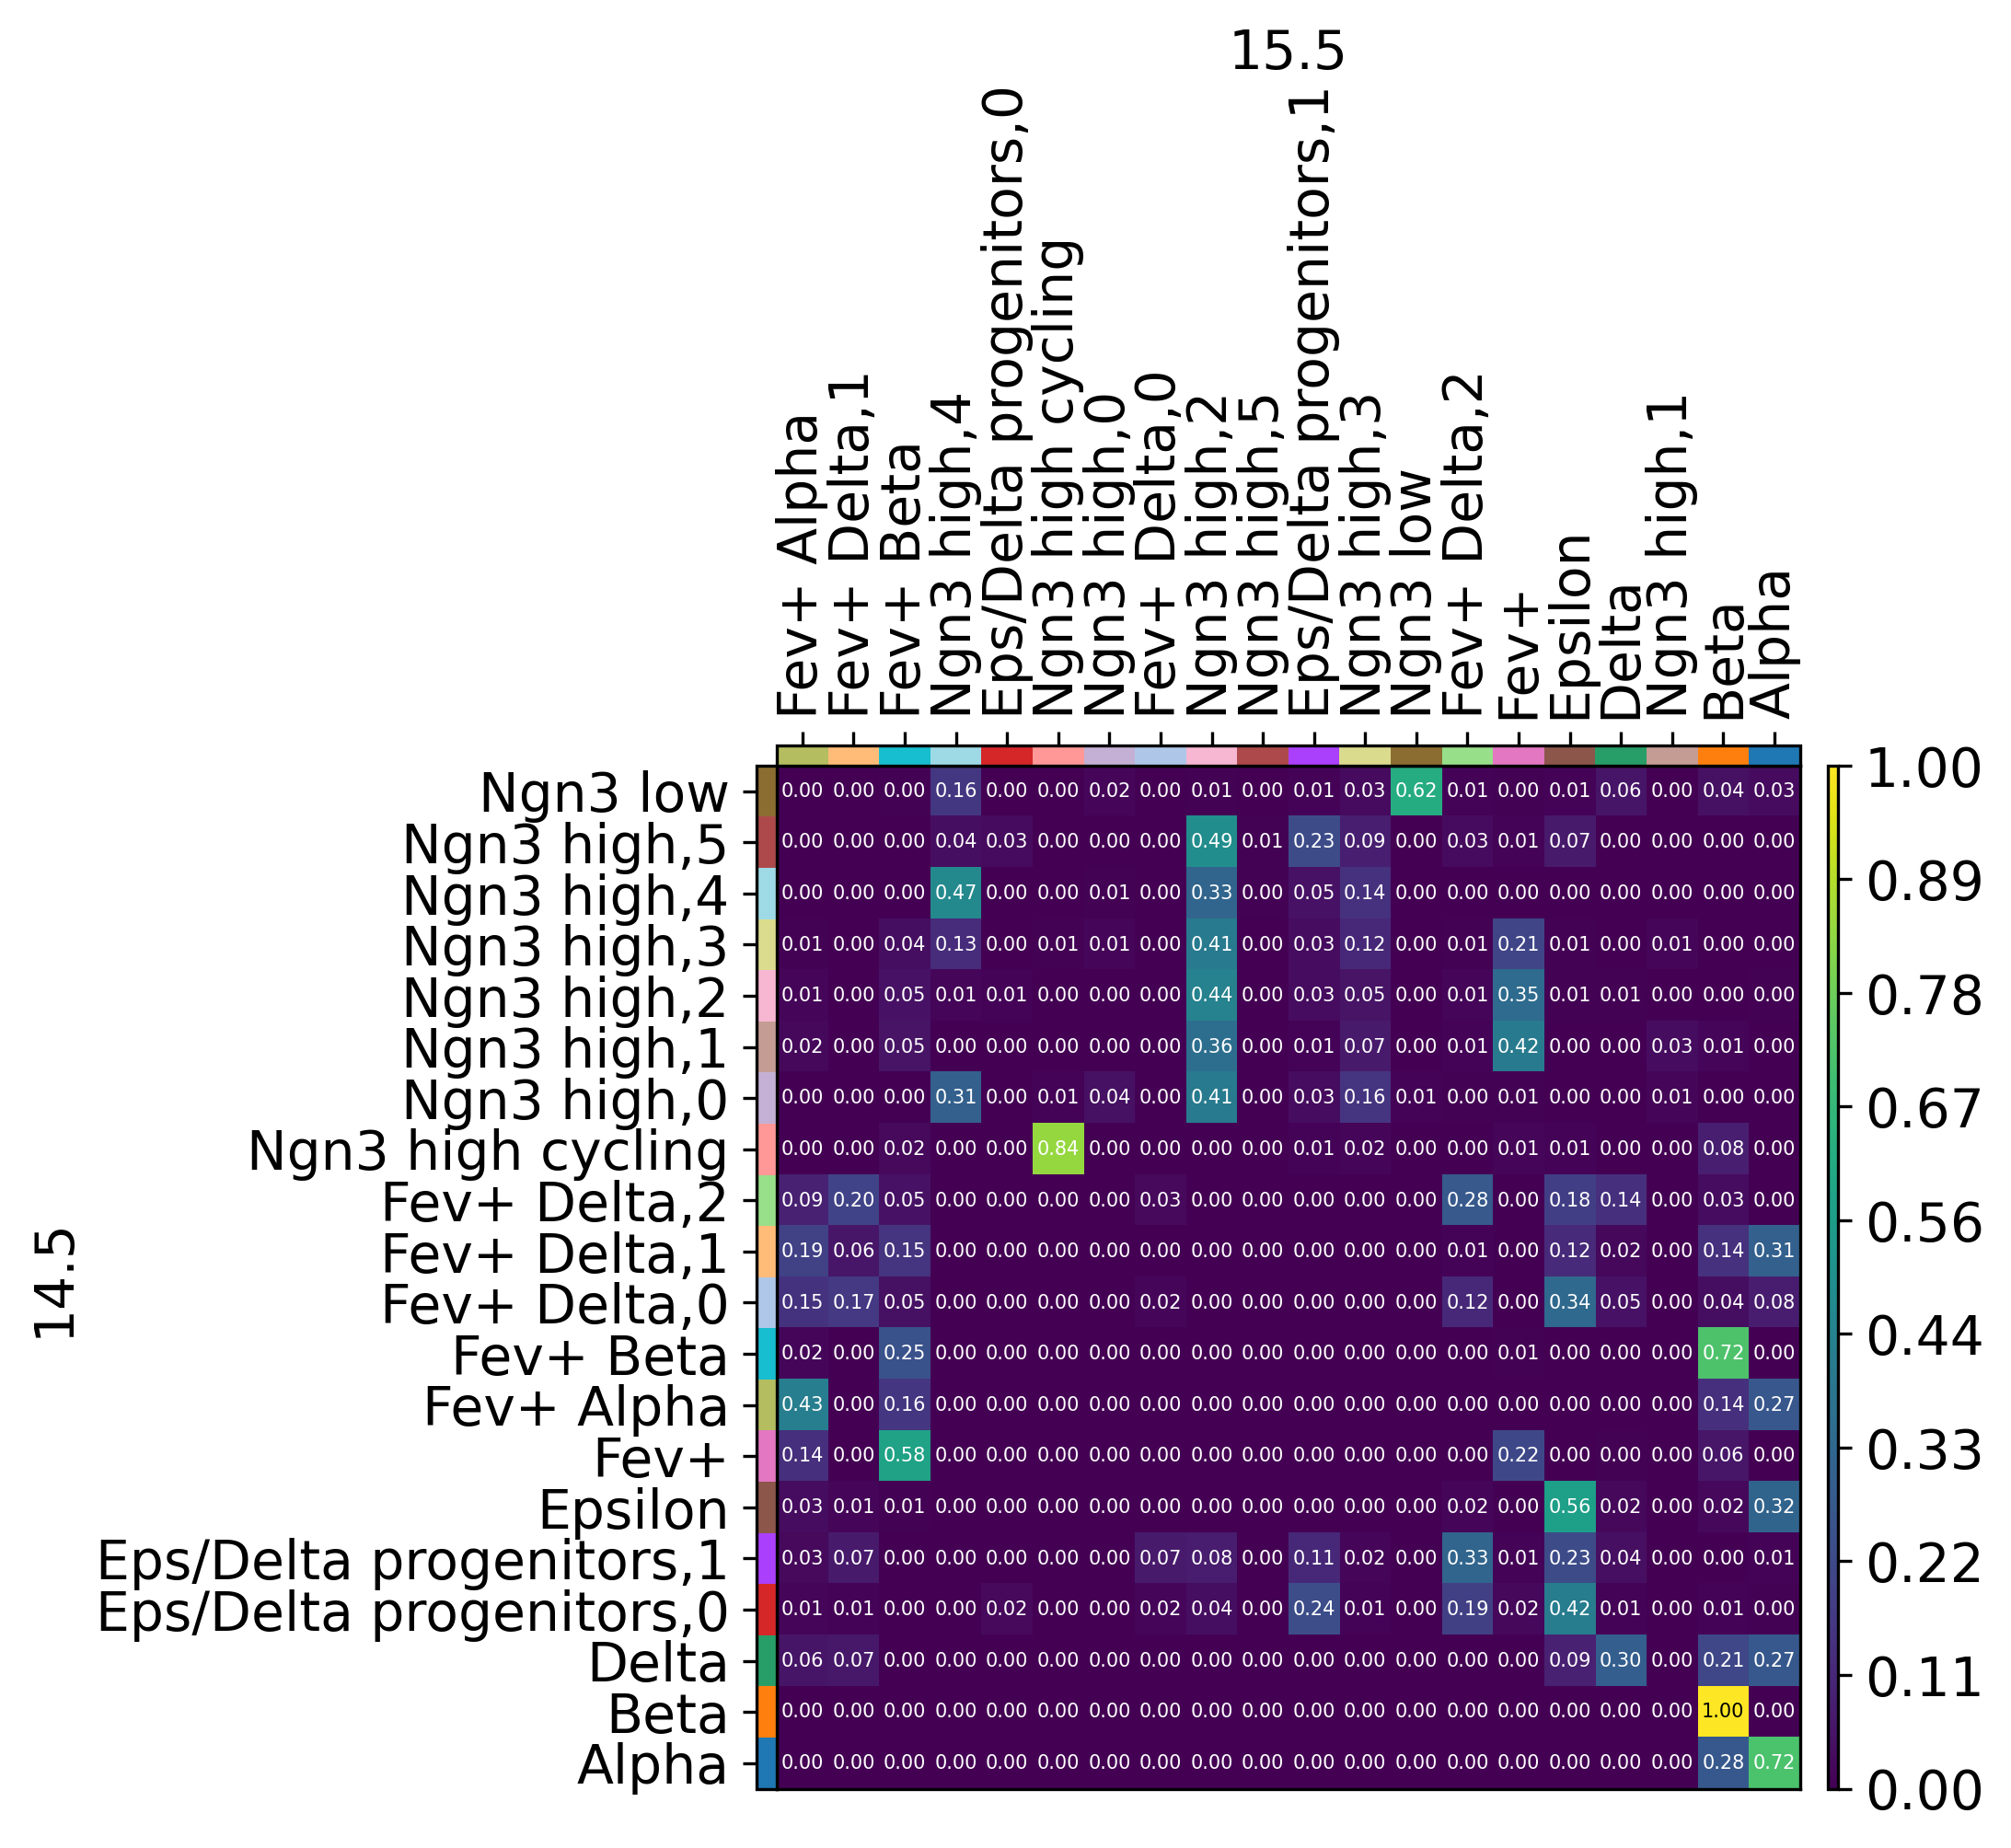

In [146]:
mpl.cell_transition(tp1, dpi=150, fontsize=5)

In [147]:
_ = tp1.cell_transition(14.5, 15.5, early_annotation="tmp_3", late_annotation="tmp_3", forward=False)

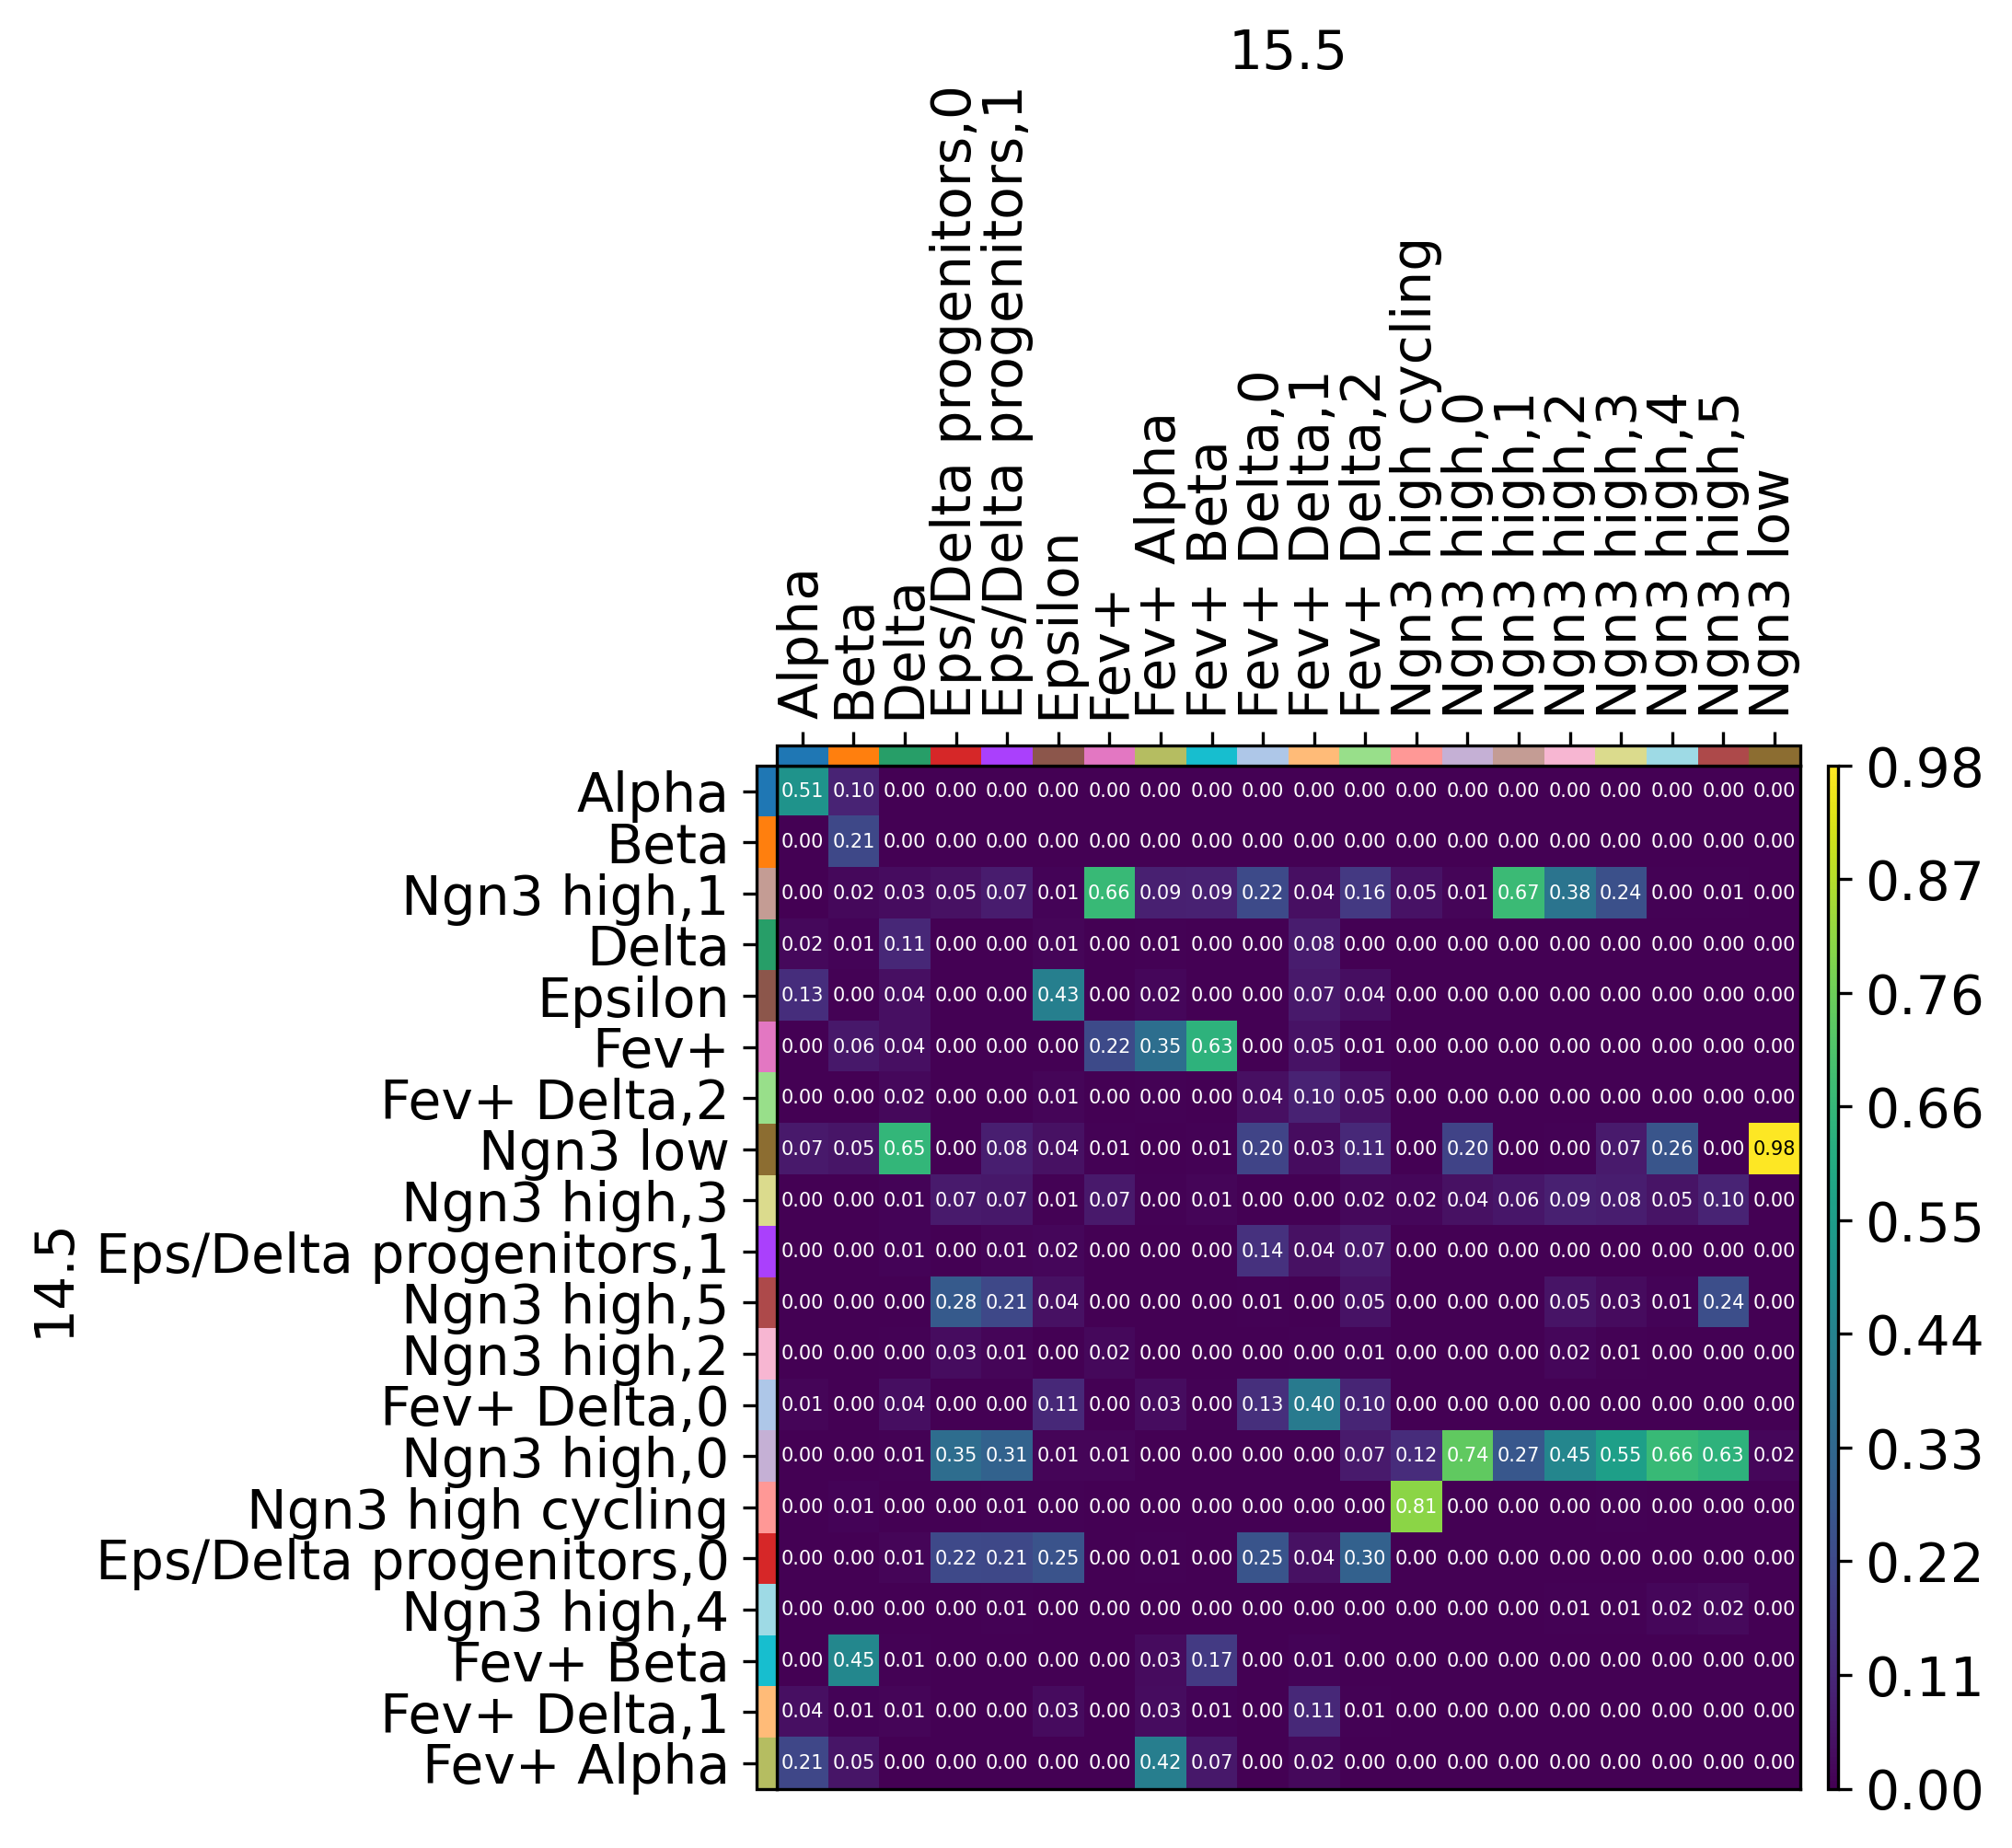

In [148]:
mpl.cell_transition(tp1, dpi=150, fontsize=5)

In [183]:
ct_to_keep = ["Fev+ Delta,0", "Fev+ Delta,1", "Fev+ Delta,2", "Eps/Delta progenitors,0", "Eps/Delta progenitors,1", "Epsilon", "Delta"]
adata_reduced_2 = adata[adata.obs["tmp_3"].isin(ct_to_keep)]

In [184]:
adata_reduced_2 = adata_reduced_2[:, adata_reduced_2.var["feature_type"]=="Gene Expression"]

In [185]:
genes_to_consider = ["Fev", "Hhex", "Gcg", "Sst", "Ghrl", "Pyy", "Ppy"]

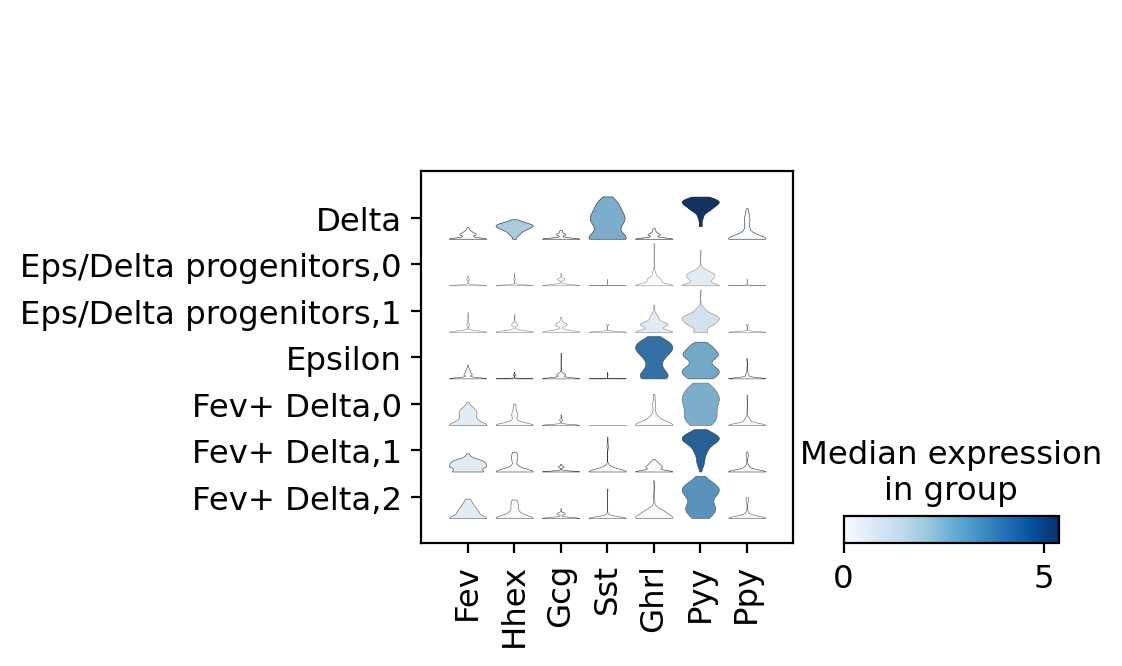

In [186]:
sc.pl.stacked_violin(adata_reduced_2, var_names=genes_to_consider, groupby="tmp_3")

In [187]:
fev_plus_eps = ['Tmem184c', 'Psmc2', 'Spint1', 'Ubl3', 'Sdcbp', 'Pclo', 'Lpcat3', 'Hpca', 'Cer1', 'Drap1', 'Lrrc42', 'Ppp3ca', 'Abhd15']

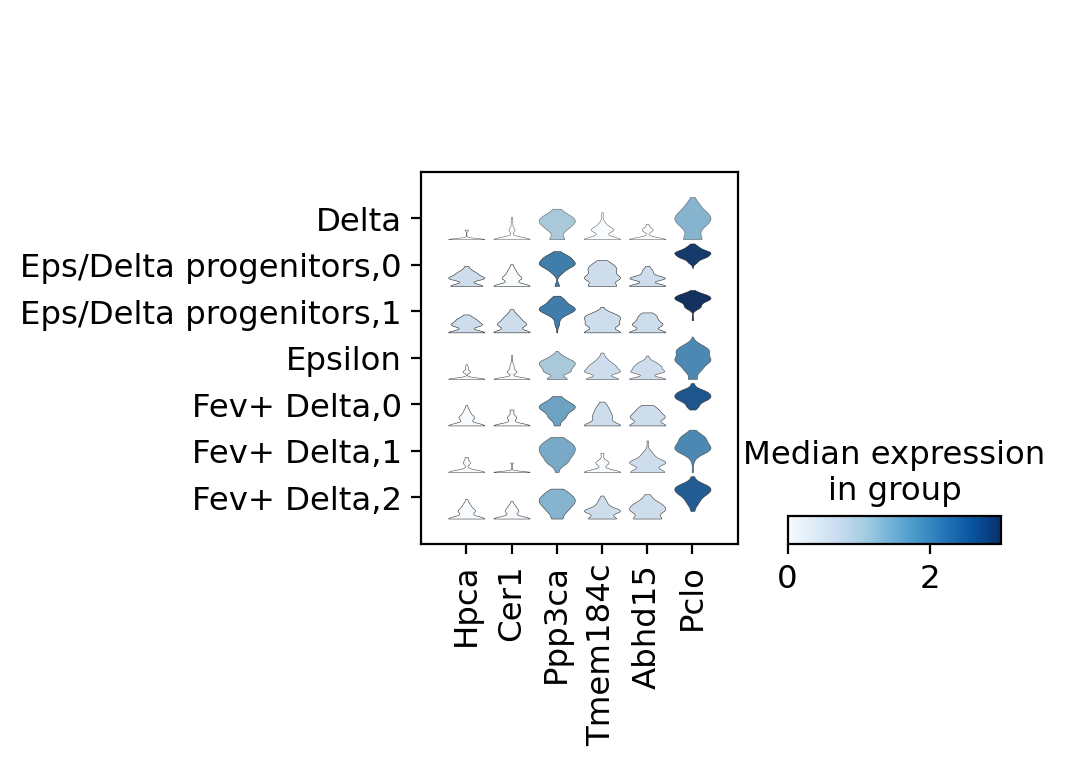

In [188]:
sc.pl.stacked_violin(adata_reduced_2, var_names=list(set(adata.var.index).intersection(set(fev_plus_eps))), groupby="tmp_3")

In [189]:
epsilon = ['Maged2', 'Txndc12', 'Prdx5', 'Cd164', 'Gng4', 'Pnmal2', 'Card19', 'Fam174a', 'Gm11837', 'Lrrtm3', 'Sin3b', 'Alcam', 'Ghrl', 'Lamp1', 'Fhl2', 'Anpep', 'Rbpms', 'Atraid', 'Ghrl', 'Maged2', 'Mboat4']

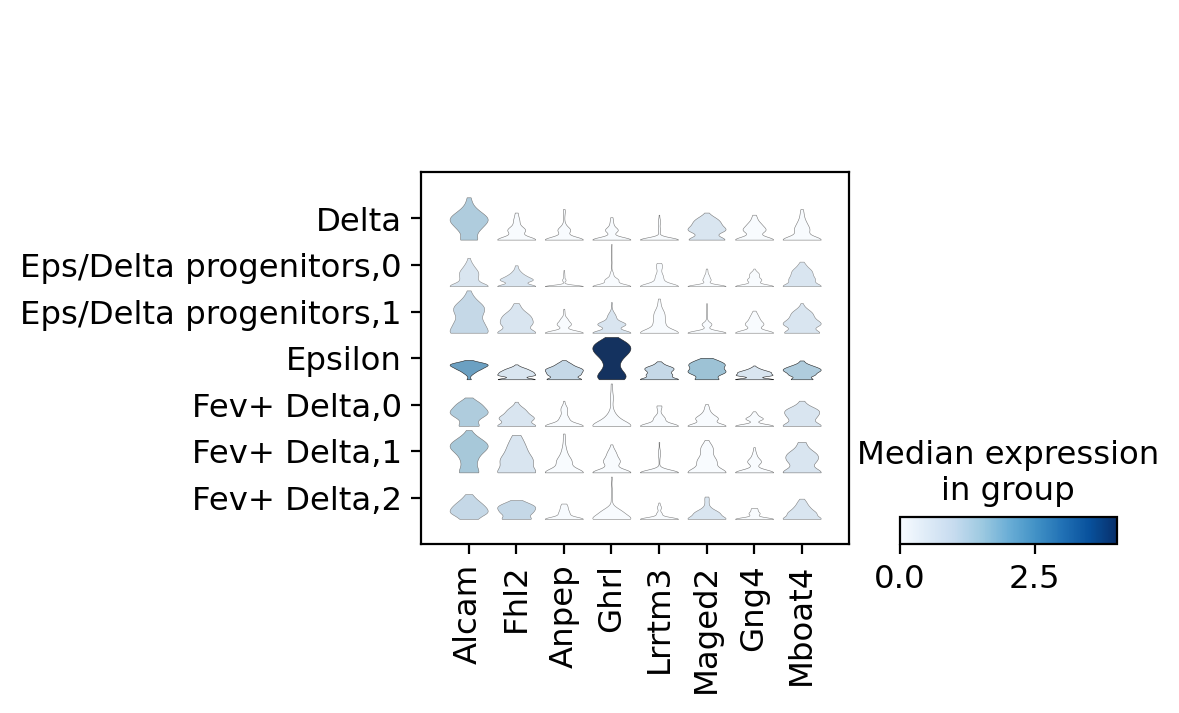

In [190]:
sc.pl.stacked_violin(adata_reduced_2, var_names=list(set(adata.var.index).intersection(set(epsilon))), groupby="tmp_3")

In [191]:
delta = ['Cd24a', 'Hhex', 'Pyy', 'Rbp4', 'Sst']

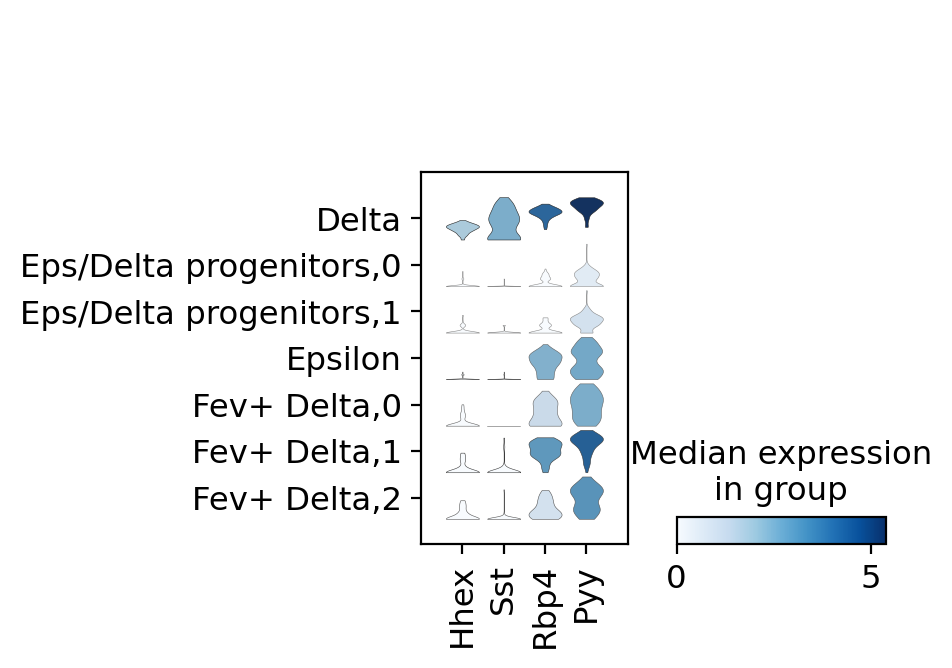

In [192]:
sc.pl.stacked_violin(adata_reduced_2, var_names=list(set(adata.var.index).intersection(set(delta))), groupby="tmp_3")

In [193]:
tp1.pull(14.5, 15.5, data="tmp_3", subset="Delta", key_added="delta_pull")

In [211]:
adata.obs["delta_pull_thresholded"] = adata.obs["delta_pull"] > np.percentile(adata.obs["delta_pull"], 98)

In [212]:
adata.obs["delta_pull_thresholded"] = adata.obs["delta_pull_thresholded"].astype(float)

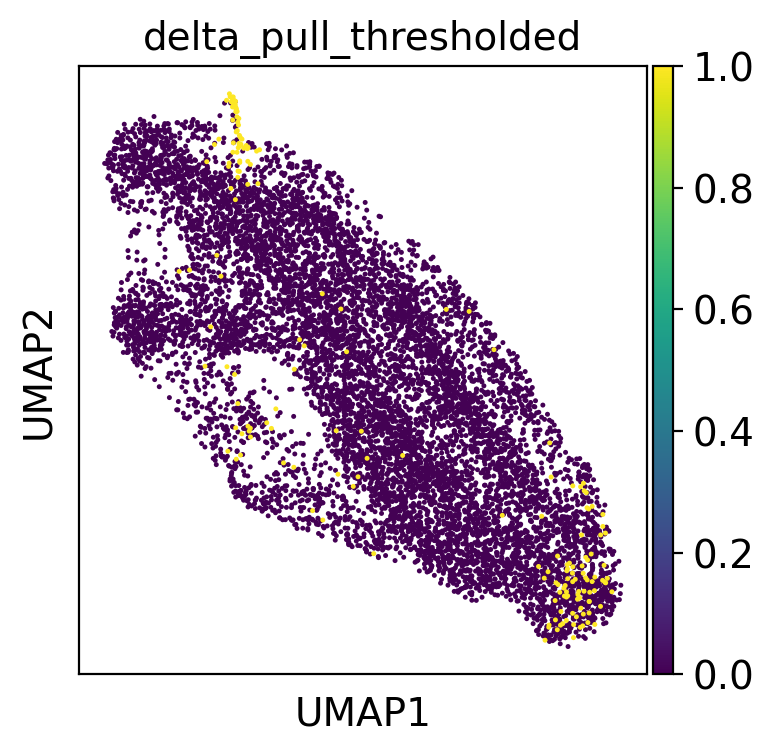

In [213]:
sc.pl.umap(adata, color="delta_pull_thresholded")

In [226]:
def helper2(x):
    if (x["celltype_refined"] == "Ngn3 low") and (x["delta_pull_thresholded"]==1):
        return "ngn3_low_pull"
    if (x["celltype_refined"] in ["Fev+ Delta"]) and (x["delta_pull_thresholded"]==1):
        return "fev_pos_pull"
    return x["celltype_refined"]

In [227]:
adata.obs["tmp_5"] = adata.obs.apply(helper2, axis=1)

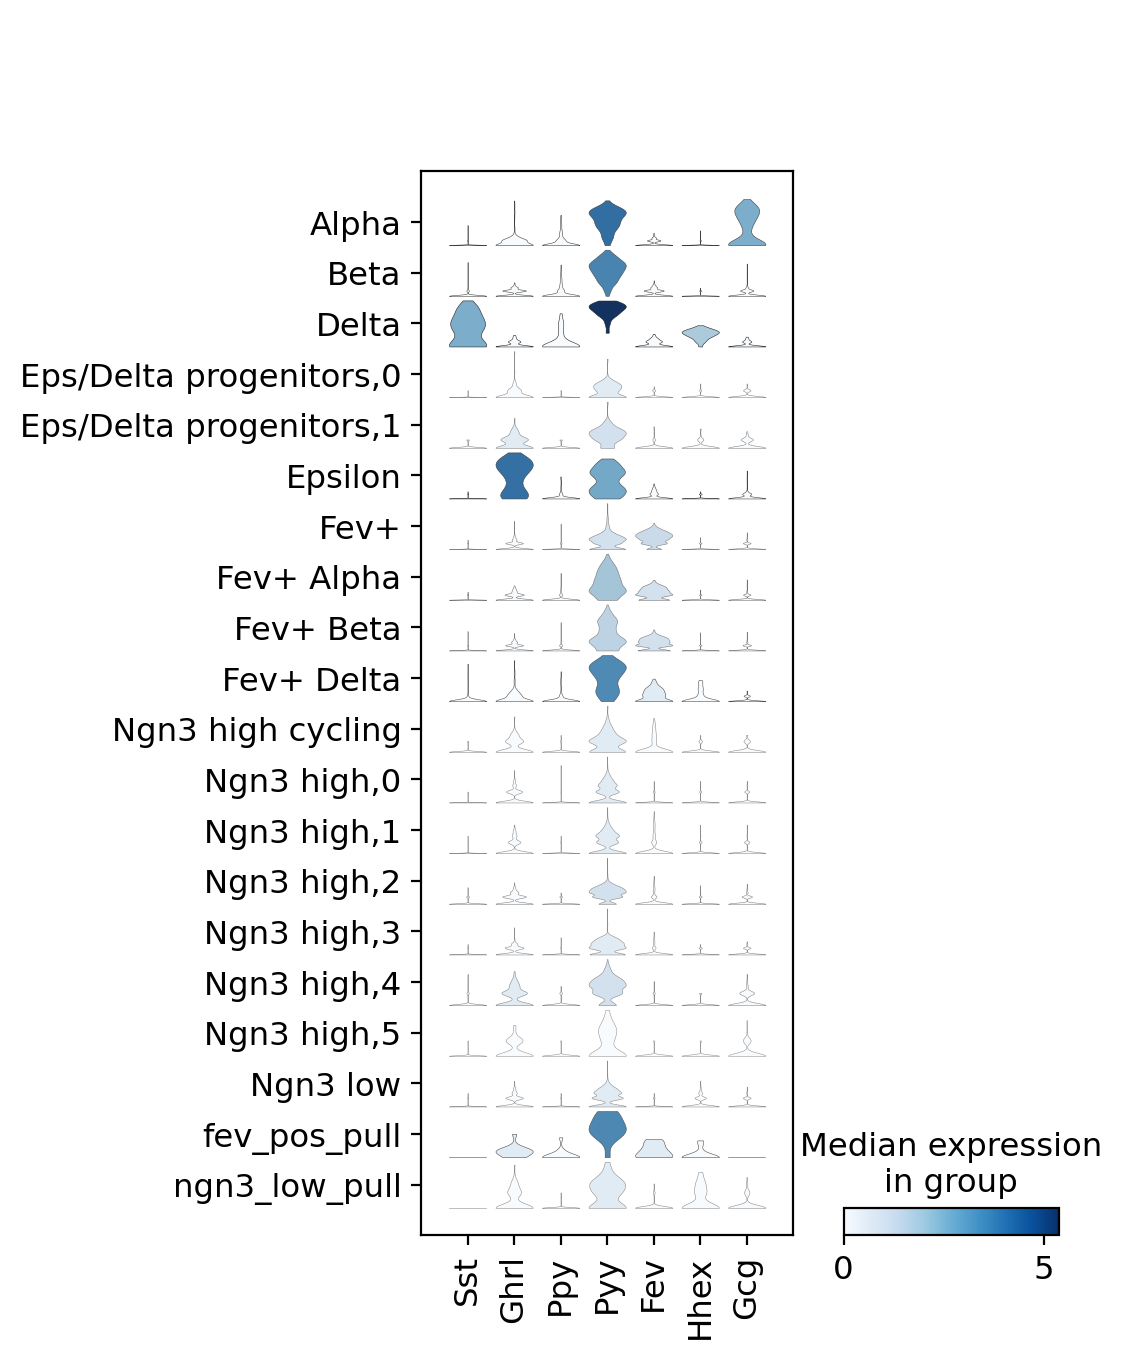

In [229]:
sc.pl.stacked_violin(adata, var_names=list(set(adata.var.index).intersection(set(genes_to_consider))), groupby="tmp_5")


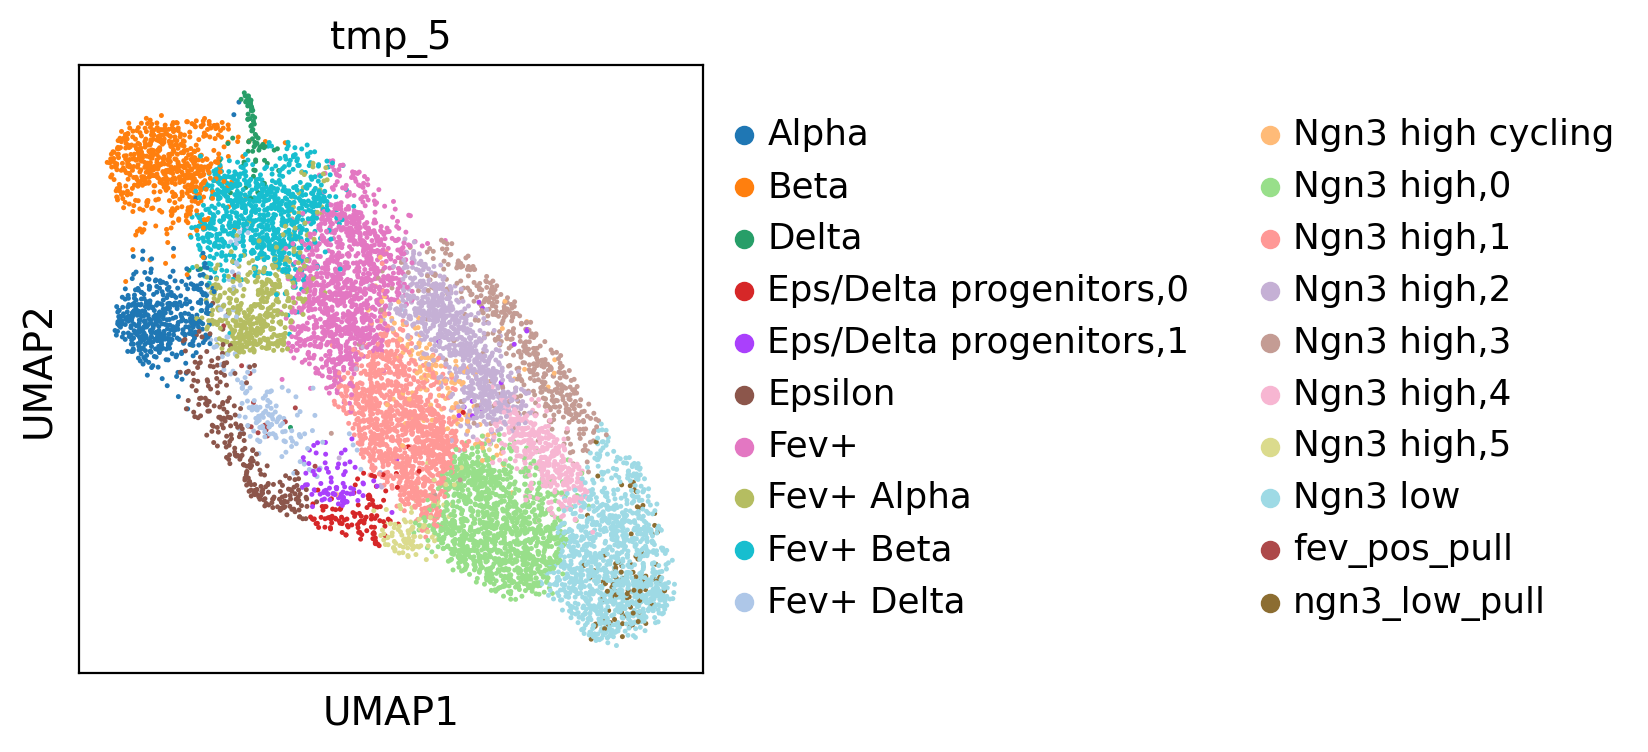

In [230]:
sc.pl.umap(adata, color="tmp_5")

In [231]:
adata.obs.to_csv()


batch_id modality  _scvi_batch               celltype  \
AAACAGCCAACAGCCT-1-0         1   paired            0             Fev+ Alpha   
AAACAGCCAACCCTCC-1-0         1   paired            0                   Fev+   
AAACAGCCACTAAGCC-1-0         1   paired            0                   Fev+   
AAACAGCCAGGATAAC-1-0         1   paired            0              Ngn3 high   
AAACAGCCATAAAGCA-1-0         1   paired            0  Eps/Delta progenitors   
...                        ...      ...          ...                    ...   
TTTGTGTTCGAGCTAT-1-1         1   paired            0              Ngn3 high   
TTTGTGTTCGATCAGT-1-1         1   paired            0                   Beta   
TTTGTGTTCTCAATGA-1-1         1   paired            0             Fev+ Alpha   
TTTGTTGGTATTGAGT-1-1         1   paired            0               Ngn3 low   
TTTGTTGGTTGTTGCT-1-1         1   paired            0                Epsilon   

                     sample  time                    tmp_1  \
AAACAGCCAACAGCCT-1-0  E14.5  14.5               Fev+ Alpha   
AAACAGCCAACCCTCC-1-0  E14.5  14.5                     Fev+   
AAACAGCCACTAAGCC-1-0  E14.5  14.5                     Fev+   
AAACAGCCAGGATAAC-1-0  E14.5  14.5                Ngn3 high   
AAACAGCCATAAAGCA-1-0  E14.5  14.5  Eps/Delta progenitors,0   
...                     ...   ...                      ...   
TTTGTGTTCGAGCTAT-1-1  E15.5  15.5                Ngn3 high   
TTTGTGTTCGATCAGT-1-1  E15.5  15.5                     Beta   
TTTGTGTTCTCAATGA-1-1  E15.5  15.5               Fev+ Alpha   
TTTGTTGGTATTGAGT-1-1  E15.5  15.5                 Ngn3 low   
TTTGTTGGTTGTTGCT-1-1  E15.5  15.5                  Epsilon   

                                        tmp_2         celltype_refined  \
AAACAGCCAACAGCCT-1-0               Fev+ Alpha               Fev+ Alpha   
AAACAGCCAACCCTCC-1-0                     Fev+                     Fev+   
AAACAGCCACTAAGCC-1-0                     Fev+                     Fev+   
AAACAGCCAGGATAAC-1-0              Ngn3 high,3              Ngn3 high,3   
AAACAGCCATAAAGCA-1-0  Eps/Delta progenitors,0  Eps/Delta progenitors,0   
...                                       ...                      ...   
TTTGTGTTCGAGCTAT-1-1              Ngn3 high,2              Ngn3 high,2   
TTTGTGTTCGATCAGT-1-1                     Beta                     Beta   
TTTGTGTTCTCAATGA-1-1               Fev+ Alpha               Fev+ Alpha   
TTTGTTGGTATTGAGT-1-1                 Ngn3 low                 Ngn3 low   
TTTGTTGGTTGTTGCT-1-1                  Epsilon                  Epsilon   

                              push      plot_tmp          pull  \
AAACAGCCAACAGCCT-1-0  0.000000e+00           NaN  7.792350e-10   
AAACAGCCAACCCTCC-1-0  0.000000e+00           NaN  1.448446e-14   
AAACAGCCACTAAGCC-1-0  0.000000e+00           NaN  2.696422e-15   
AAACAGCCAGGATAAC-1-0  0.000000e+00           NaN  1.282859e-12   
AAACAGCCATAAAGCA-1-0  0.000000e+00           NaN  2.318834e-09   
...                            ...           ...           ...   
TTTGTGTTCGAGCTAT-1-1  1.138095e-19  1.138095e-19  0.000000e+00   
TTTGTGTTCGATCAGT-1-1  2.513233e-15  2.513233e-15  0.000000e+00   
TTTGTGTTCTCAATGA-1-1  2.205803e-05  2.205803e-05  0.000000e+00   
TTTGTTGGTATTGAGT-1-1  9.419568e-44  9.419568e-44  0.000000e+00   
TTTGTTGGTTGTTGCT-1-1  1.064465e-04  1.064465e-04  0.000000e+00   

                       celltype_refined_delta                    tmp_3  \
AAACAGCCAACAGCCT-1-0               Fev+ Alpha               Fev+ Alpha   
AAACAGCCAACCCTCC-1-0                     Fev+                     Fev+   
AAACAGCCACTAAGCC-1-0                     Fev+                     Fev+   
AAACAGCCAGGATAAC-1-0              Ngn3 high,3              Ngn3 high,3   
AAACAGCCATAAAGCA-1-0  Eps/Delta progenitors,0  Eps/Delta progenitors,0   
...                                       ...                      ...   
TTTGTGTTCGAGCTAT-1-1              Ngn3 high,2              Ngn3 high,2   
TTTGTGTTCGATCAGT-1-1                     Beta         